# Feature Engineering for Power Flow Constraint Amplitude Detection Case Study
The objective of this notebook is to asses and generate the most important features that allow the prediction of the amplitude of low voltage constraints of a power flow. 

Summary:
- Data set and target feature description.
- Mutual Information Analyisis.

## Data 
### Baseline Features
The baseline dataset will be the `exogenous_data` from the `strategy_desin_pattern.ipynb`. It contains the features that are external to the electrical system. The present feature are:
- `T`: Temperature Forecast [K].
- `R`: Irradiance Forecast [W/m2].
- `wind_speed`: Wind Speed Forecast [m/s].
- `wind_direction`: Wind Direction Forecast [degrees].

In [ ]:
import pandas as pd
import numpy as np
pv_data = pd.read_csv('..\data\processed\production\pv_data_processed.csv')
pv_data.drop(['year', 'month', 'value', 'normalized_value', 'date'], axis=1, inplace=True)
wind_data = pd.read_csv('..\data\processed\production\wind_data_processed.csv')
wind_data.drop(['year', 'month', 'value', 'normalized_value', 'T', 'R'], axis=1, inplace=True)
exogenous_data = pd.DataFrame(
    {'T': pv_data['T'],
     'R': pv_data['R'],
     'date': wind_data['date'],
     'wind_speed': wind_data['wind_speed'],
     'wind_direction': wind_data['wind_direction']
    }
)
# convert date column to datetime.
exogenous_data['date'] = pd.to_datetime(exogenous_data['date'])

### Target Data
Since the objective of this case study is to forecast the amplitude of low voltage constraints, our target data are the bus are the negative values of the voltage magnitude minus the lower voltage limit.
$$ 
    target_{bus}(t)  = Relu(V_{limit} - V_{bus}(t)) [pu]
$$

The network used is the is the 33-bus system described the notebook `strategy_design_pattern.ipynb`. 

In [2]:
output = pd.read_csv('..\data\ground_truth\pf_res_bus_vm_pu.csv')
timestamp_index = output['timestamps']
output.drop(['timestamps'], axis=1, inplace=True)

Setting the lower limit to 0.95 pu, the amplitude of the low voltage constraints are:

In [3]:
#output = output.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
output = output.apply(lambda x: (x-1.05).apply(lambda y: max(0, y)))

Our dataset has plenty of low voltage constraints. The following plot shows the distribution of the amplitude of the low voltage constraints.

Text(0, 0.5, 'Voltage Constraint Amplitude [pu]')

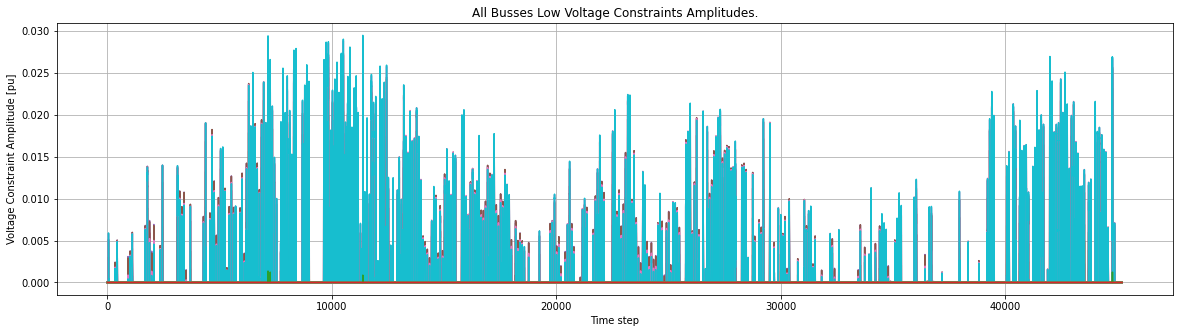

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Matplotlib defaults
output.plot(legend=False, figsize=(20,5)); plt.grid(); plt.title('All Busses Low Voltage Constraints Amplitudes.'); plt.xlabel('Time step'); plt.ylabel('Voltage Constraint Amplitude [pu]')

### New Features
The following features are generated from the baseline features:
- `season`: Season of the year.
- `weekday`: Weekday of the year.
- `last_hour_mean_wind_speed`: Mean wind speed of the last hour.
- `last_day_mean_wind_direction`: Mean wind direction of the last hour.
- `last_hour_mean_temperature`: Mean temperature of the last hour.
- `last_hour_mean_irradiance`: Mean irradiance of the last hour.

In [5]:
# Create Season feature on the basis of the date.
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else: 
        raise ValueError('Invalid month')
exogenous_data['season'] = exogenous_data.apply(lambda x: get_season(x['date']), axis=1)
# Bar plot with the count of each season.
season_count = exogenous_data['season'].value_counts()


In [6]:
# Create weekday feature on the basis of the date.
def get_weekday(date):
    return date.isoweekday()
exogenous_data['weekday'] = exogenous_data.apply(lambda x: get_weekday(x['date']), axis=1)

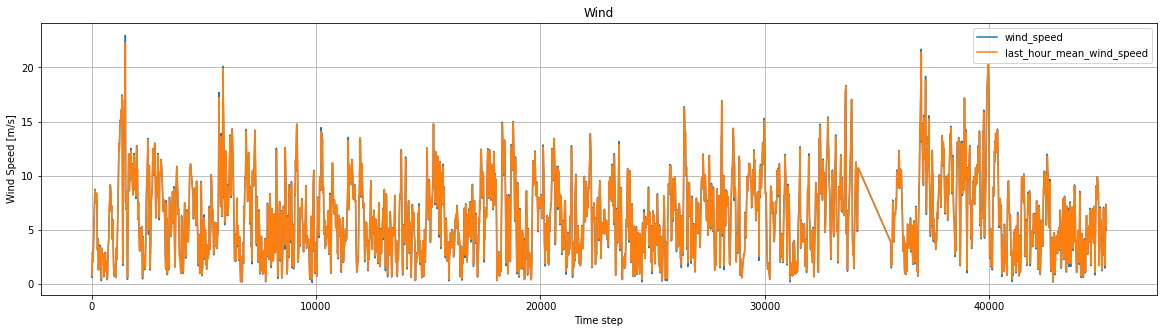

In [7]:
# Create last hour mean wind speed feature. Last hour seems to be too little.
exogenous_data['last_hour_mean_wind_speed'] = exogenous_data.wind_speed.rolling(4, min_periods=1).mean()
exogenous_data.wind_speed.plot(legend=False, figsize=(20,5)); 
exogenous_data.last_hour_mean_wind_speed.plot(legend=False, figsize=(20,5))
plt.title('Wind')
plt.xlabel('Time step'); plt.ylabel('Wind Speed [m/s]')
plt.grid()
plt.legend()
plt.show()

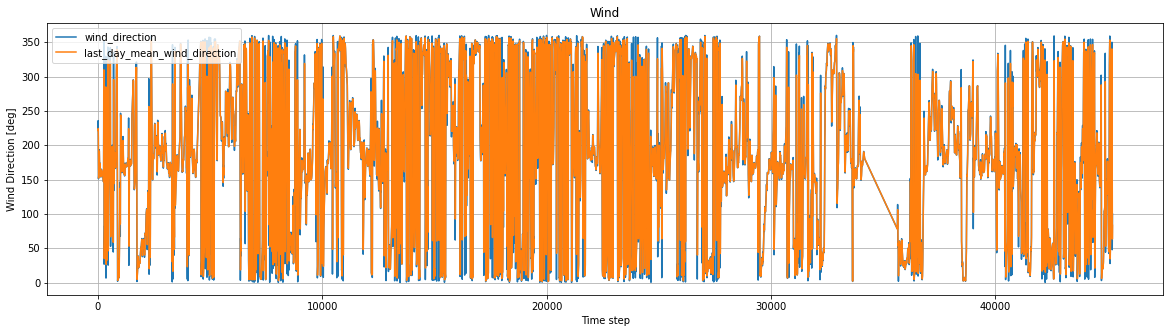

In [8]:
# Create last day mean wind direction feature.
exogenous_data['last_day_mean_wind_direction'] = exogenous_data.wind_direction.rolling(8, min_periods=1).mean()
exogenous_data.wind_direction.plot(legend=False, figsize=(20,5)); 
exogenous_data.last_day_mean_wind_direction.plot(legend=False, figsize=(20,5))
plt.title('Wind')
plt.xlabel('Time step'); plt.ylabel('Wind Direction [deg]')
plt.grid()
plt.legend()
plt.show()

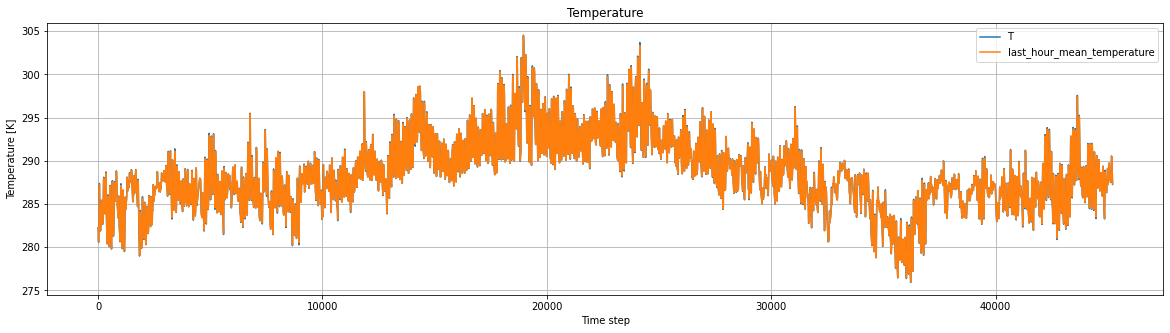

In [9]:
# Create last hour mean temperature feature.
exogenous_data['last_hour_mean_temperature'] = exogenous_data['T'].rolling(4, min_periods=1).mean()
exogenous_data['T'].plot(legend=False, figsize=(20,5)); 
exogenous_data.last_hour_mean_temperature.plot(legend=False, figsize=(20,5))
plt.title('Temperature')
plt.xlabel('Time step'); plt.ylabel('Temperature [K]')
plt.grid()
plt.legend()
plt.show()

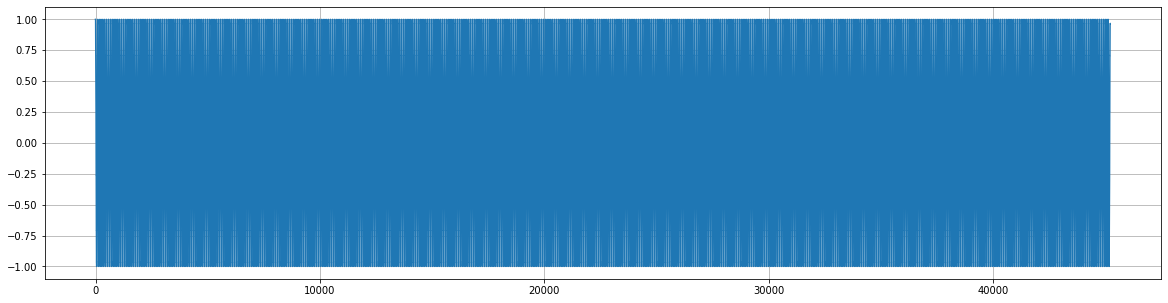

In [10]:
# Compute the sin of the hour of the day, given a pd.Series(). 
exogenous_data['cos_hour_day'] = exogenous_data.apply(lambda x: np.cos(2*np.pi*x['date'].hour/24), axis=1)
exogenous_data['cos_hour_day'].plot(legend=False, figsize=(20,5));plt.grid();plt.show()

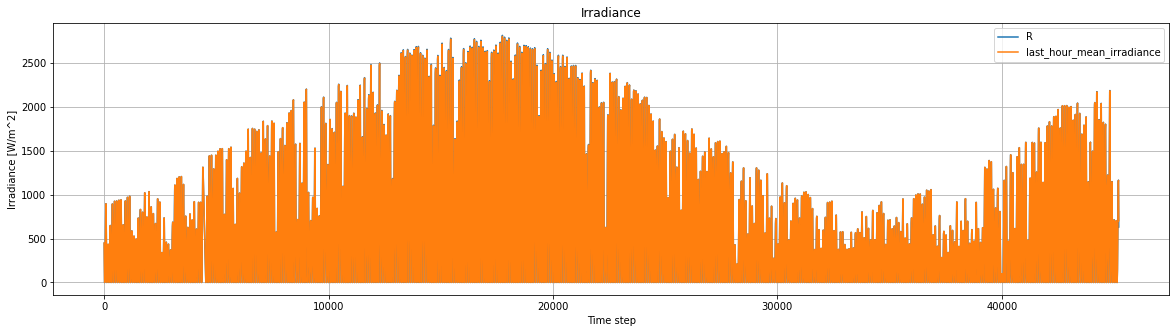

In [11]:
# Create last hour mean irradiance feature.
exogenous_data['last_hour_mean_irradiance'] = exogenous_data['R'].rolling(4, min_periods=1).mean()
exogenous_data['R'].plot(legend=False, figsize=(20,5)); 
exogenous_data.last_hour_mean_irradiance.plot(legend=False, figsize=(20,5))
plt.title('Irradiance')
plt.xlabel('Time step'); plt.ylabel('Irradiance [W/m^2]')
plt.grid()
plt.legend()
plt.show()    

In [12]:
# Write to csv the exogenous data with new features.
exogenous_data.to_csv('..\data\processed\production\exogenous_data_extended.csv', index=False)

# Mutual Information Analysis
** TODO: Describe Mutual Information Analysis ** 


In [13]:
from sklearn.feature_selection import mutual_info_regression
# Function that calculates de MI scores
def compute_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [14]:
df = pd.DataFrame()
# Convert date column to string.
exogenous_data.drop(['date'], axis=1, inplace=True)
#exogenous_data['date'] = exogenous_data['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
for bus in output.columns:
    mi_scores = compute_mi_scores(exogenous_data, output[bus])
    df[bus] = mi_scores

Text(0.5, 1.0, 'MI scores for each bus.')

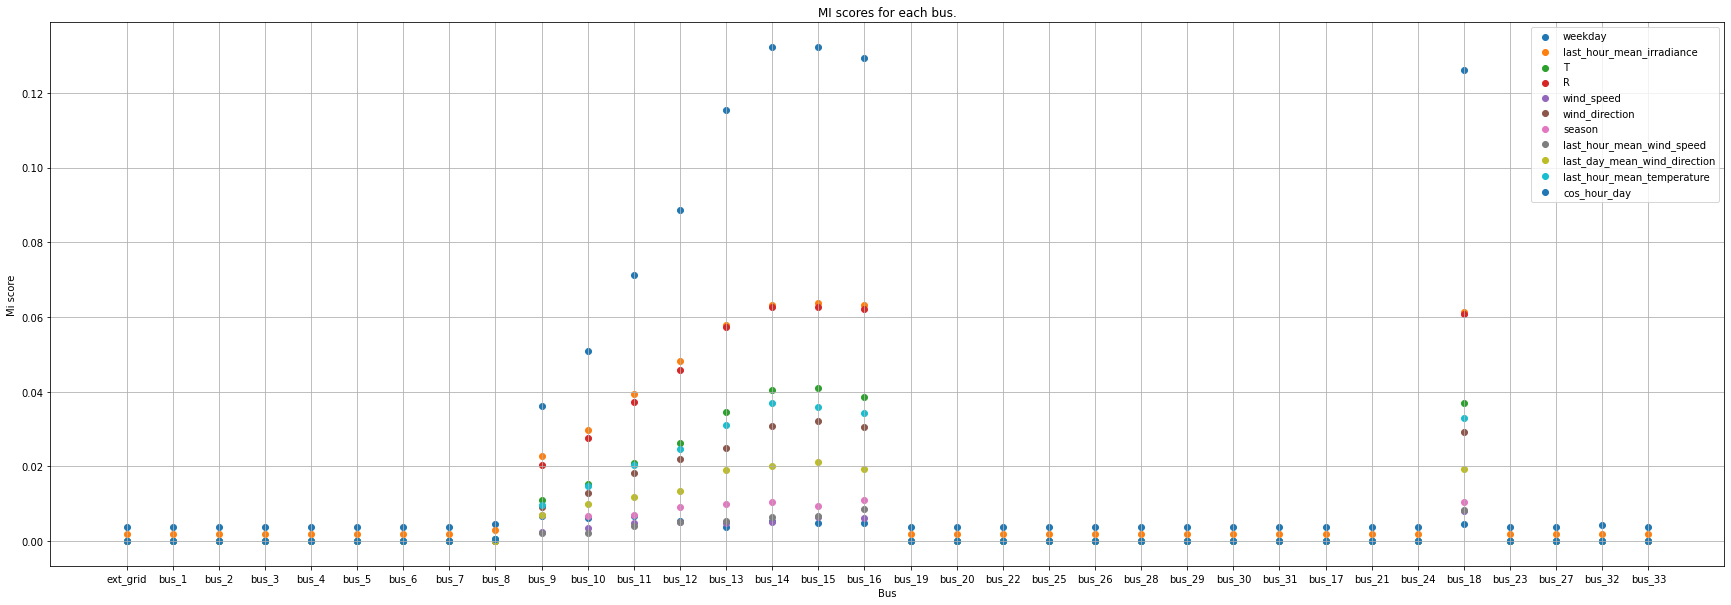

In [25]:
# Plot the MI scores for each bus. In the y axis the features, and the x axis the bus.
fig, ax = plt.subplots(figsize=(30,10))
plt.grid()
for feature in df.index.values:
    plt.scatter(df.columns, df.loc[feature])
plt.legend(df.index.values)
plt.ylabel('Mi score')
plt.xlabel('Bus')
plt.title('MI scores for each bus.')


## Explore Results
### Network Topology and Constraints
From the plot above, we can see that the MI scores are higher for a certain group of busses. Moreover, the MI scores for all the other busses stay the same. **Why**?

First it is useful to investigate wather these busses are connected to each other.

In [ ]:
import sys
sys.path.append('..')
from thesis_package import utils as ut, extractor as ex, elements as el  

network = el.Network()
network.create_network_from_xlsx(xlsx_file_path="..\\data\\raw\\Data_Example_32.xlsx")
# Create the pandapower network.
network.create_pandapower_model() # Property name: net_model.
# Plot the network.
network.plot_network()

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\jupyter_notebooks\..\data\raw\Data_Example_32.xlsx


No or insufficient geodata available --> Creating artificial coordinates. This may take some time...
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\pandapower\plotting\plotly\traces.py:483: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  branches_to_plot = net[branch_element].loc[set(net[branch_element].index) & (set(branches) - no_go_branches)]
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\pandapower\plotting\plotly\simple_plotly.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hoverinfo = pd.Series(index=hover_index, data=hoverinfo)


From the network topology, we can see that the busses are connected to each other in a stream.

In [ ]:
res_bus_vm_pu = pd.read_csv('..\\data\\ground_truth\\pf_res_bus_vm_pu.csv')
res_bus_vm_pu.head(2)

ext_grid     bus_1     bus_2     bus_3     bus_4     bus_5     bus_6  \
0  0.996427  0.996427  0.987222  0.983481  0.981681  0.974967  0.965655   
1  0.996644  0.996644  0.987691  0.984094  0.982351  0.975803  0.966573   

      bus_7     bus_8     bus_9  ...    bus_31    bus_17    bus_21    bus_24  \
0  0.963978  0.962022  0.954723  ...  0.975902  0.976677  0.978617  0.979252   
1  0.964909  0.962950  0.955595  ...  0.977034  0.977823  0.979776  0.980414   

     bus_18    bus_23    bus_27    bus_32  bus_33           timestamps  
0  0.945441  0.991628  0.981255  0.980017     1.0  2020-01-01 00:00:00  
1  0.946146  0.991944  0.981696  0.981185     1.0  2020-01-01 00:15:00  

[2 rows x 35 columns]

Since these busses are connected to each other, we can check if these are the bussed that are breaking the constraint voltages.

In [ ]:
def get_voltage_constraints_boolean_map(df, max_u=None, min_u=None):
    result = {'max_u': pd.DataFrame(), 'min_u': pd.DataFrame()}
    # Any value in the df that is over max_u is set to True. Save the result in the result['max_u'] dataframe.
    try: 
        if max_u is not None:
            result['max_u'] = df.drop(['timestamps'], axis=1).apply(lambda x: x > max_u, axis=1)
        # Any value in the df that is under min_u is set to True. Save the result in the result['max_u'] dataframe.
        if min_u is not None:
            result['min_u'] = df.drop(['timestamps'], axis=1).apply(lambda x: x < min_u, axis=1)
    except Exception as e:
        print(e)
        print('Unable to create Voltage Boolean Constraints.')
    return result
res_bus_constraints_boolean_map = get_voltage_constraints_boolean_map(res_bus_vm_pu, max_u=1.05, min_u=0.95)

Now, can count how many time in a year, each bus breaks the constraint voltages.

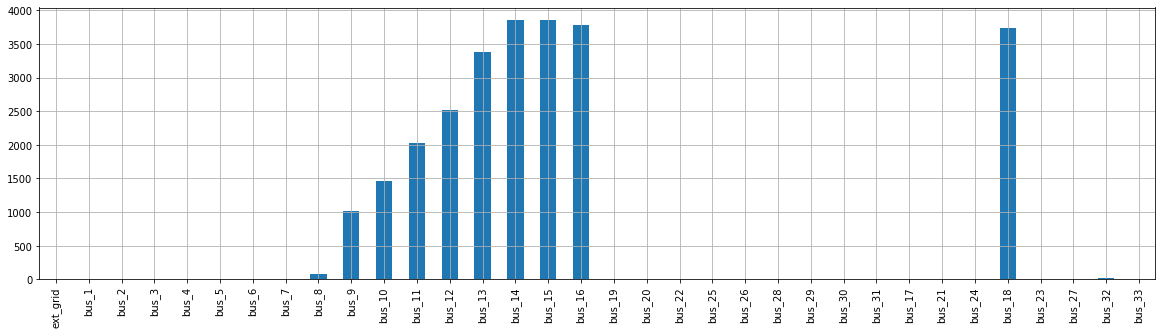

In [ ]:
res_bus_constraints_boolean_map['max_u'][res_bus_constraints_boolean_map['max_u'] == True ].sum().plot(kind='bar', figsize=(20,5))
plt.grid()
plt.show()

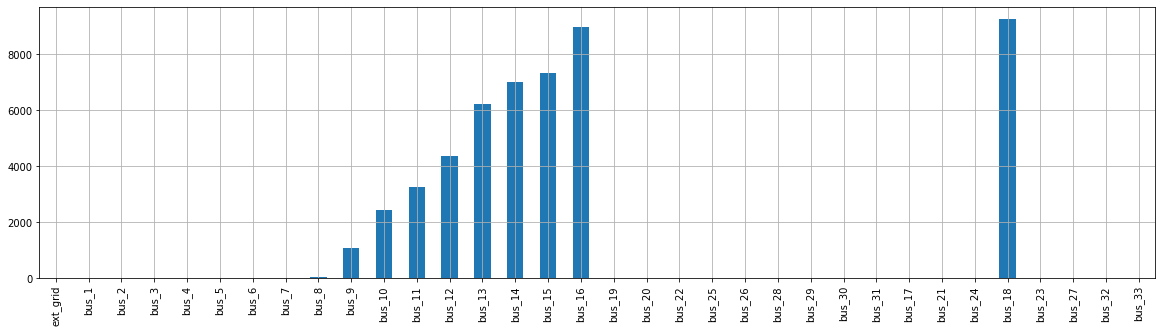

In [ ]:
res_bus_constraints_boolean_map['min_u'][res_bus_constraints_boolean_map['min_u'] == True ].sum().plot(kind='bar', figsize=(20,5))
plt.grid()
plt.show()

From the barplots above, we can conclude that the busses with the **highest MI score is the bus that breaks the constraint voltages**.

### Distribution of most Important Features in the Dataset with Regards to the Output
The following plot shows the distribution of the most important features in the dataset with regards to the output of each bus.

6


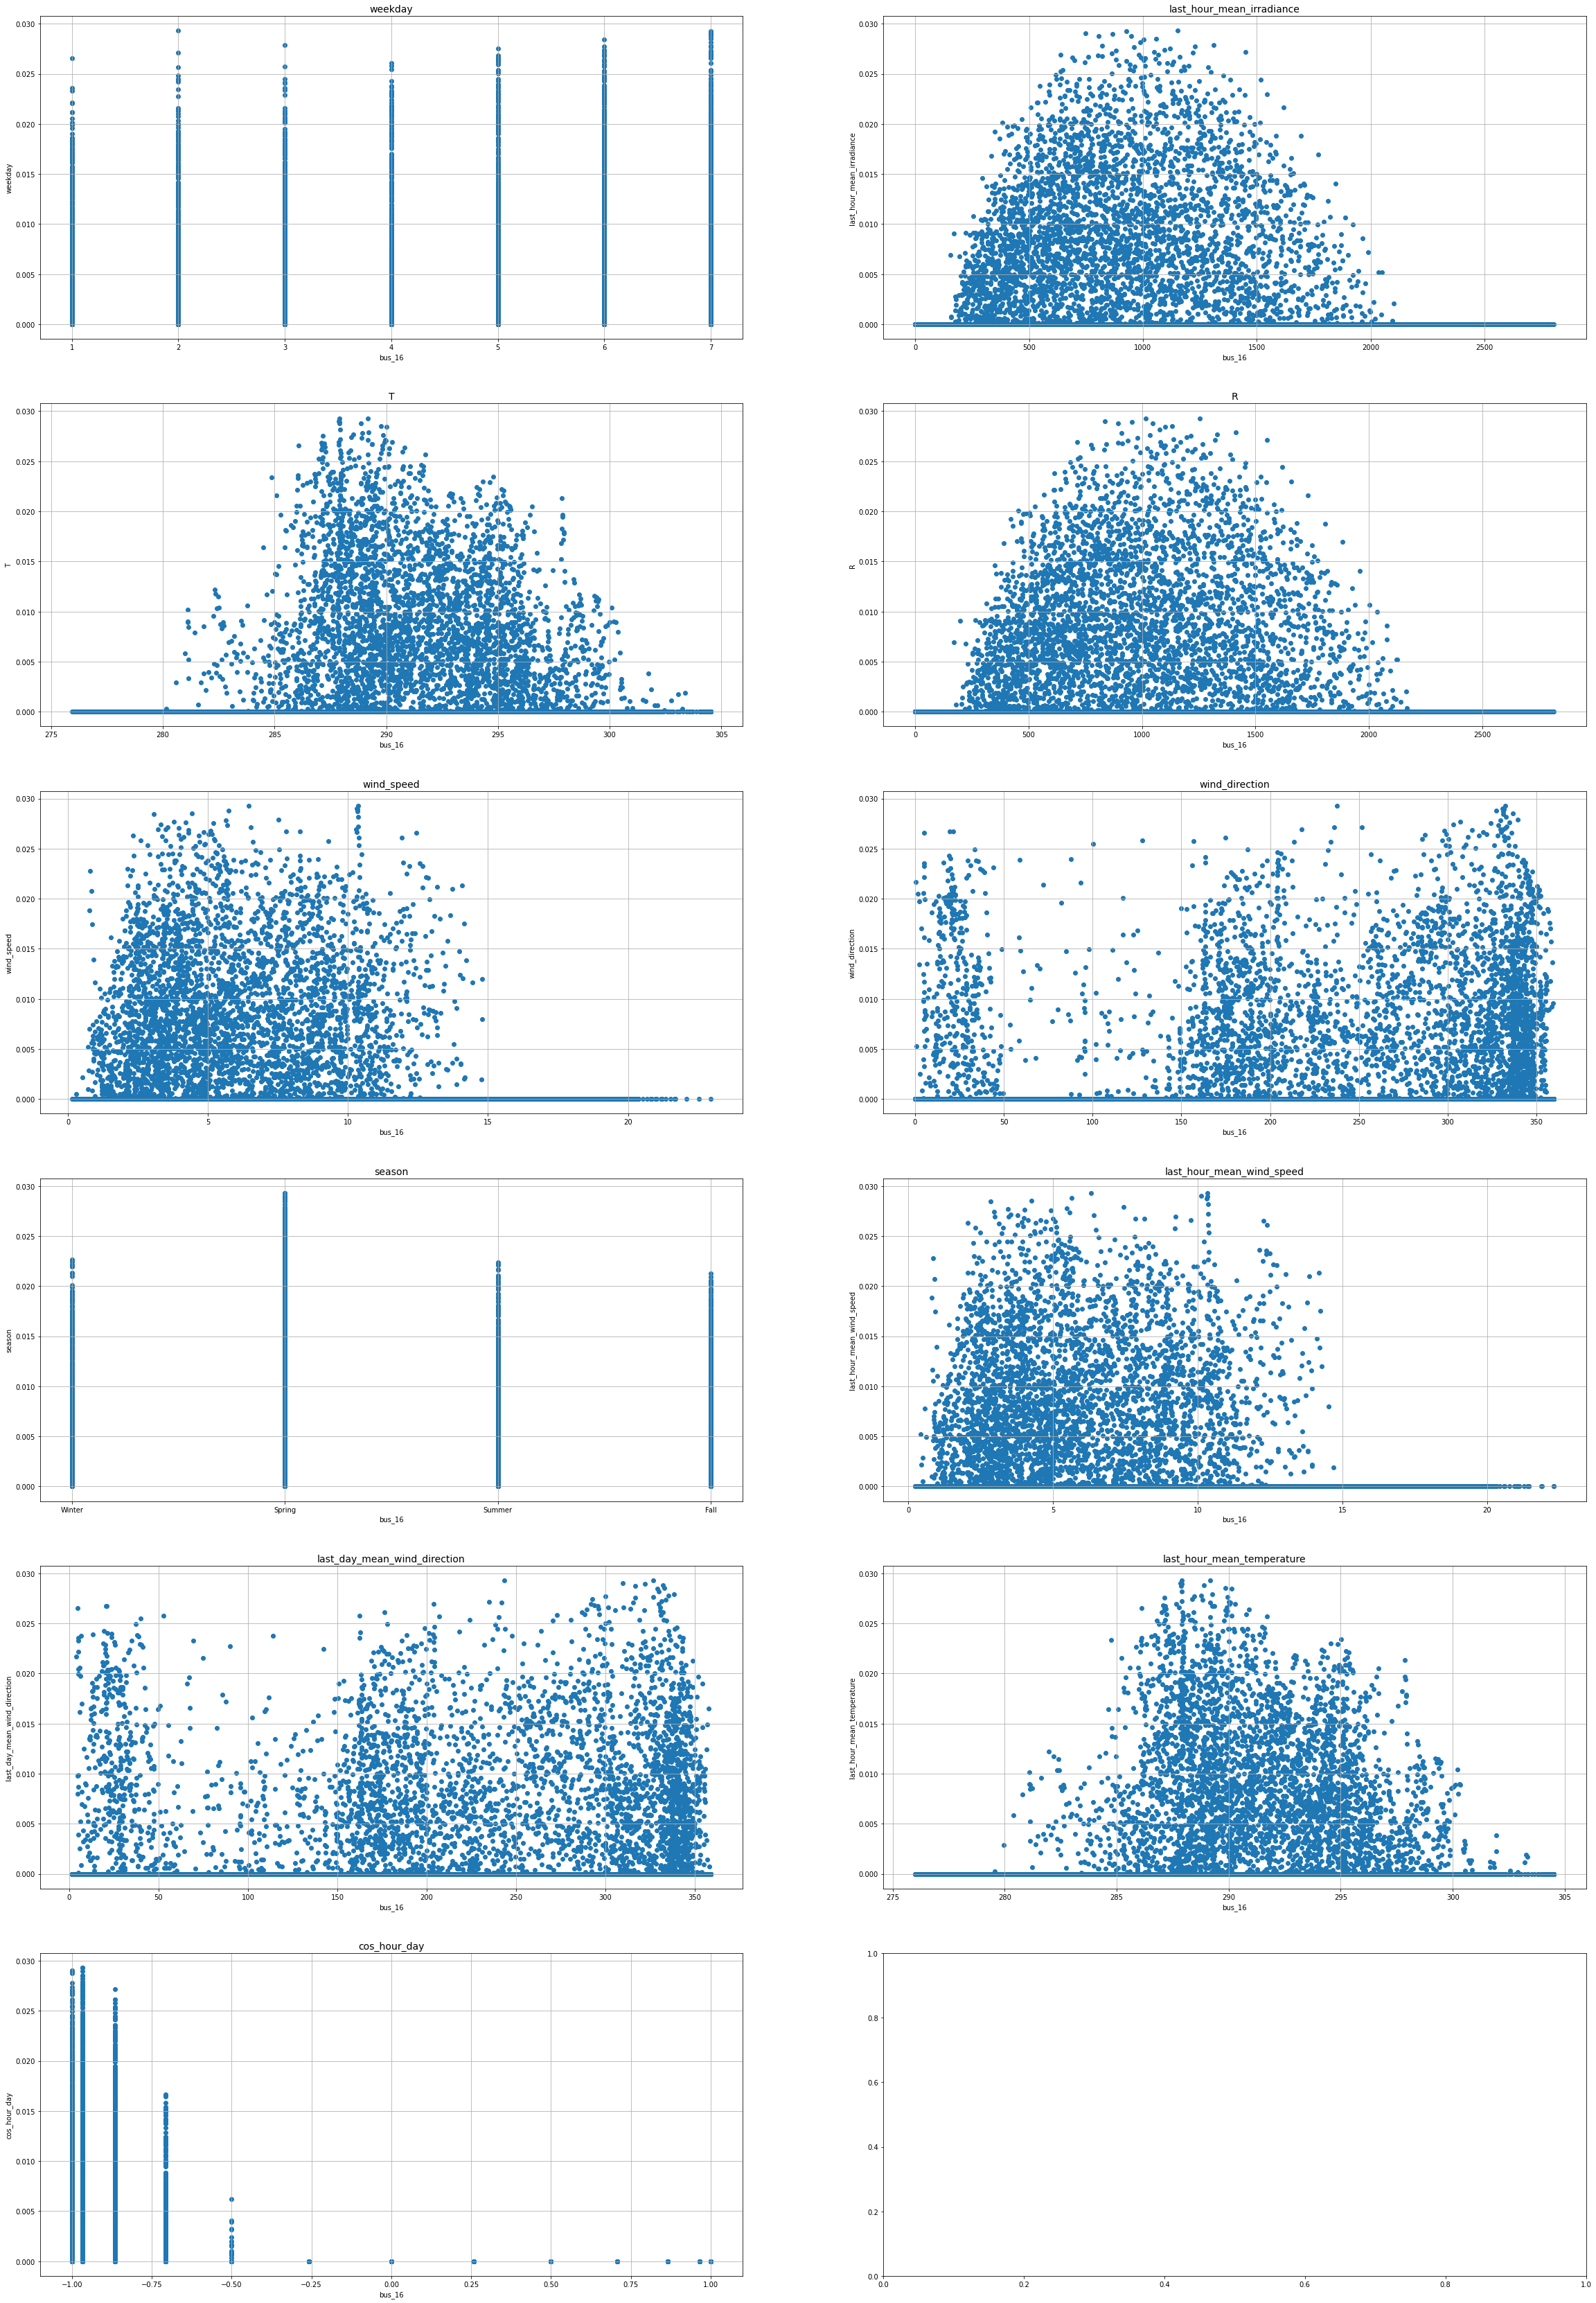

In [ ]:
from math import ceil 
import itertools
# plot  the distribution of the most important features in the dataset with regards to the output of a given bus.
def plot_distribution_scatter(output, mi_scores, bus):
    # Each subplot will be the the distribution of a certain feature. Each feature will be one that contains an MI score different than zero.
    target_features = list(mi_scores[bus][mi_scores[bus] > 0].index)
    num_rows = ceil(len(target_features)/2) 
    print(num_rows)
    num_cols = 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(40,num_rows*10))
    for row, col in itertools.product(range(num_rows), range(num_cols)):
        if row*num_cols+col < len(target_features):
            if num_rows == 1:
                feature = target_features[row*num_cols+col]
                axs[col].scatter(exogenous_data[feature], output[bus])
            else: 
                feature = target_features[row*num_cols+col]
                axs[row, col].scatter(exogenous_data[feature], output[bus])
                axs[row, col].set_title(feature, fontsize=14)
                axs[row, col].set_xlabel(bus)
                axs[row, col].set_ylabel(feature)
                axs[row, col].grid()
    plt.show()
plot_distribution_scatter(output, df, 'bus_16')